# Artificial Neural Networks and Deep Learning

---

## Lecture 6a: Autoencoders

<img src="https://drive.google.com/uc?export=view&id=1E28s8D4qMjpeYKXBM2uPNRB_XeL1jIOr" width="500"/>

## 🌐 Connect Colab to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/[2024-2025] AN2DL/Lecture 6

## ⚙️ Import Libraries

In [ ]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)


from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd


# Configure plot display settings
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.17.1


## ⏳ Load and Process Data

In [ ]:
# Load the data
(X_train_val, y_train_val), (X_test, y_test) = tfk.datasets.mnist.load_data()

# Add channel dimension before resizing (smart_resize expects shape [batch, height, width, channels])
X_train_val = X_train_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# Resize to 32x32
X_train_val = tfk.preprocessing.image.smart_resize(X_train_val, (32, 32))
X_test = tfk.preprocessing.image.smart_resize(X_test, (32, 32))

# Normalize pixel values
X_train_val = X_train_val.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Class names for reference
class_names = ['Zero', 'One', 'Two', 'Three', 'Four', 'Five', 'Six', 'Seven', 'Eight', 'Nine']

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


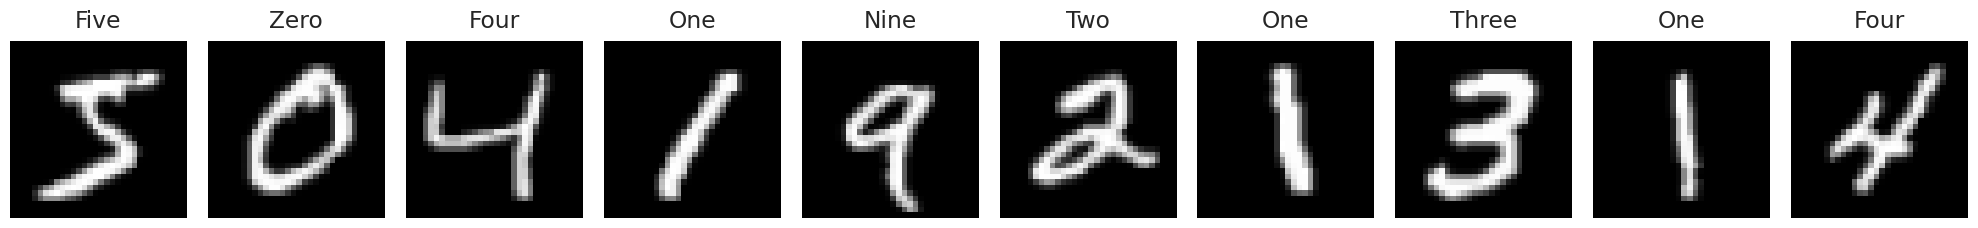

In [ ]:
# Inspect the data
fig, axes = plt.subplots(1, 10, figsize=(20,10))
for i in range(10):
    ax = axes[i%10]
    ax.imshow(np.squeeze(X_train_val[i]), cmap='gray')
    ax.set_title(class_names[y_train_val[i]], pad=10)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Split between train and validation
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=len(X_test), random_state=seed, stratify=y_train_val)
print("Training data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)
print("Test data shape:", X_test.shape)

Training data shape: (50000, 32, 32, 1)
Validation data shape: (10000, 32, 32, 1)
Test data shape: (10000, 32, 32, 1)


In [ ]:
# Define the input shape based on the training data
input_shape = X_train.shape[1:]

# Define the latent dimension for dimensionality reduction or feature extraction
latent_dim = 2

# Set the learning rate for the optimizer
learning_rate = 1e-3

# Define the batch size for training
batch_size = 128

# Set the number of epochs for training
epochs = 1000

# Print the configurations to verify their correctness
print(f'Input shape: {input_shape}')
print(f'Latent dimension: {latent_dim}')
print(f'Learning rate: {learning_rate}')
print(f'Batch size: {batch_size}')
print(f'Epochs: {epochs}')

Input shape: (32, 32, 1)
Latent dimension: 2
Learning rate: 0.001
Batch size: 128
Epochs: 1000


## 🛠️ Build and Train the Autoencoder

<img src="https://it.mathworks.com/discovery/autoencoder/_jcr_content/mainParsys/image.adapt.480.medium.svg/1708410150207.svg" width="700">

In [ ]:
def get_encoder(enc_input_shape=input_shape, enc_output_shape=latent_dim, seed=seed):
    # Set the random seed for reproducibility
    tf.random.set_seed(seed)

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=enc_input_shape, name='input_layer')

    # First convolution block
    x = tfkl.Conv2D(32, 3, 2, padding='same')(input_layer)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.LeakyReLU()(x)

    # Second convolution block
    x = tfkl.Conv2D(64, 3, 2, padding='same')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.LeakyReLU()(x)

    # Third convolution block
    x = tfkl.Conv2D(128, 3, 2, padding='same')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.LeakyReLU()(x)

    # Flatten the output of the last convolution layer
    x = tfkl.Flatten()(x)
    # Define the output layer with the specified output shape
    output_layer = tfkl.Dense(enc_output_shape, name='output_layer')(x)

    # Create the model linking input and output
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='encoder')

    return model

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer (InputLayer)            │ (None, 32, 32, 1)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv2d (Conv2D)                     │ (None, 16, 16, 32)           │           320 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ batch_normalization                 │ (None, 16, 16, 32)           │           128 │    Y    │
│ (BatchNormalization)                │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ leaky_re_lu (LeakyReLU)             │ (None, 16, 16, 32)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv2d_1 (Conv2D)                   │ (None, 8, 8, 64)             │        18,496 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ batch_normalization_1               │ (None, 8, 8, 64)             │           256 │    Y    │
│ (BatchNormalization)                │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ leaky_re_lu_1 (LeakyReLU)           │ (None, 8, 8, 64)             │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv2d_2 (Conv2D)                   │ (None, 4, 4, 128)            │        73,856 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ batch_normalization_2               │ (None, 4, 4, 128)            │           512 │    Y    │
│ (BatchNormalization)                │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ leaky_re_lu_2 (LeakyReLU)           │ (None, 4, 4, 128)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ flatten (Flatten)                   │ (None, 2048)                 │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ output_layer (Dense)                │ (None, 2)                    │         4,098 │    Y    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 97,666 (381.51 KB)

 Trainable params: 97,218 (379.76 KB)

 Non-trainable params: 448 (1.75 KB)

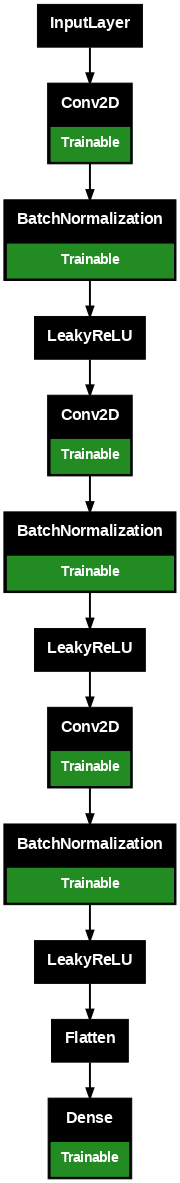

In [ ]:
encoder = get_encoder()

# Print a detailed summary of the encoder with expanded nested layers and trainable parameters.
encoder.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the encoder architecture.
tf.keras.utils.plot_model(encoder, show_trainable=True, expand_nested=True, dpi=70)

In [ ]:
def get_decoder(dec_input_shape=(latent_dim,), dec_output_shape=input_shape, seed=seed):
    # Set the random seed for reproducibility
    tf.random.set_seed(seed)

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=dec_input_shape, name='input_layer')

    # Start the decoder network with a dense layer
    # and reshape into the desired initial convolutional shape
    x = tfkl.Dense(4*4*128)(input_layer)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.LeakyReLU()(x)
    x = tfkl.Reshape((4, 4, 128))(x)

    # First upsampling and convolution block
    x = tfkl.UpSampling2D(interpolation='bilinear')(x)
    x = tfkl.Conv2D(128, 3, padding='same')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.LeakyReLU()(x)

    # Second upsampling and convolution block
    x = tfkl.UpSampling2D(interpolation='bilinear')(x)
    x = tfkl.Conv2D(64, 3, padding='same')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.LeakyReLU()(x)

    # Third upsampling and convolution block
    x = tfkl.UpSampling2D(interpolation='bilinear')(x)
    x = tfkl.Conv2D(32, 3, padding='same')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.LeakyReLU()(x)

    # Apply a final convolution with the number of channels equal to the original image depth
    x = tfkl.Conv2D(dec_output_shape[-1], 3, padding='same')(x)

    # Sigmoid activation to ensure output values between 0 and 1
    output_layer = tfkl.Activation('sigmoid')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='decoder')

    return model

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer (InputLayer)            │ (None, 2)                    │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense (Dense)                       │ (None, 2048)                 │         6,144 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ batch_normalization_3               │ (None, 2048)                 │         8,192 │    Y    │
│ (BatchNormalization)                │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ leaky_re_lu_3 (LeakyReLU)           │ (None, 2048)                 │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ reshape (Reshape)                   │ (None, 4, 4, 128)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ up_sampling2d (UpSampling2D)        │ (None, 8, 8, 128)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv2d_3 (Conv2D)                   │ (None, 8, 8, 128)            │       147,584 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ batch_normalization_4               │ (None, 8, 8, 128)            │           512 │    Y    │
│ (BatchNormalization)                │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ leaky_re_lu_4 (LeakyReLU)           │ (None, 8, 8, 128)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ up_sampling2d_1 (UpSampling2D)      │ (None, 16, 16, 128)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv2d_4 (Conv2D)                   │ (None, 16, 16, 64)           │        73,792 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ batch_normalization_5               │ (None, 16, 16, 64)           │           256 │    Y    │
│ (BatchNormalization)                │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ leaky_re_lu_5 (LeakyReLU)           │ (None, 16, 16, 64)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ up_sampling2d_2 (UpSampling2D)      │ (None, 32, 32, 64)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv2d_5 (Conv2D)                   │ (None, 32, 32, 32)           │        18,464 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ batch_normalization_6               │ (None, 32, 32, 32)           │           128 │    Y    │
│ (BatchNormalization)                │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ leaky_re_lu_6 (LeakyReLU)           │ (None, 32, 32, 32)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv2d_6 (Conv2D)    

 Total params: 255,361 (997.50 KB)

 Trainable params: 250,817 (979.75 KB)

 Non-trainable params: 4,544 (17.75 KB)

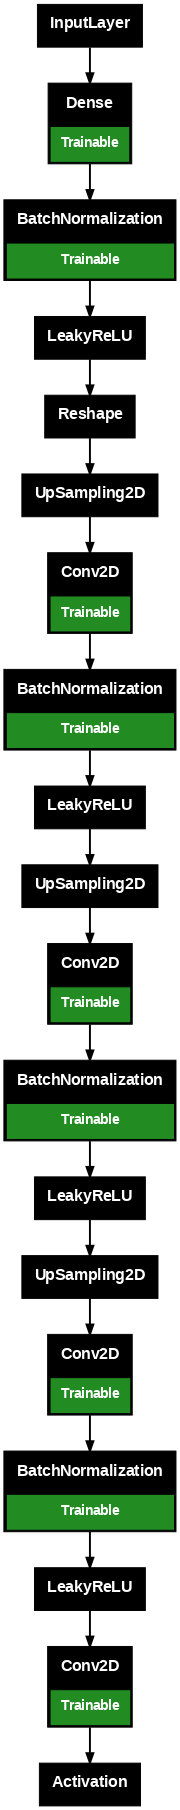

In [ ]:
decoder = get_decoder()

# Print a detailed summary of the decoder with expanded nested layers and trainable parameters.
decoder.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the decoder architecture.
tf.keras.utils.plot_model(decoder, show_trainable=True, expand_nested=True, dpi=70)

In [ ]:
def get_autoencoder(ae_input_shape=input_shape, ae_output_shape=input_shape):
    # Set the random seed to ensure reproducibility
    tf.random.set_seed(seed)

    # Initialize the encoder and decoder models
    encoder = get_encoder()
    decoder = get_decoder()

    # Define the input layer
    input_layer = tfkl.Input(shape=ae_input_shape)

    # Pass input through the encoder to get the compressed representation
    z = encoder(input_layer)

    # Pass the representation through the decoder to reconstruct the input
    output_layer = decoder(z)

    # Create the autoencoder model
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='autoencoder')
    return model

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer (InputLayer)            │ (None, 32, 32, 1)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ encoder (Functional)                │ (None, 2)                    │        97,666 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ input_layer (InputLayer)       │ (None, 32, 32, 1)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ conv2d_7 (Conv2D)              │ (None, 16, 16, 32)           │           320 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ batch_normalization_7          │ (None, 16, 16, 32)           │           128 │    Y    │
│ (BatchNormalization)                │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ leaky_re_lu_7 (LeakyReLU)      │ (None, 16, 16, 32)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ conv2d_8 (Conv2D)              │ (None, 8, 8, 64)             │        18,496 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ batch_normalization_8          │ (None, 8, 8, 64)             │           256 │    Y    │
│ (BatchNormalization)                │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ leaky_re_lu_8 (LeakyReLU)      │ (None, 8, 8, 64)             │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ conv2d_9 (Conv2D)              │ (None, 4, 4, 128)            │        73,856 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ batch_normalization_9          │ (None, 4, 4, 128)            │           512 │    Y    │
│ (BatchNormalization)                │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ leaky_re_lu_9 (LeakyReLU)      │ (None, 4, 4, 128)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ flatten_1 (Flatten)            │ (None, 2048)                 │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ output_layer (Dense)           │ (None, 2)                    │         4,098 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ decoder (Functional)                │ (None, 32, 32, 1)            │       255,361 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ input_layer (InputLayer)       │ (None, 2)                    │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ dense_1 (Dense)                │ (None, 2048)                 │         6,144 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ batch_normalization_10         │ (None, 2048)                 │         8,192 │    Y    │
│ (BatchNormalization) 

 Total params: 353,027 (1.35 MB)

 Trainable params: 348,035 (1.33 MB)

 Non-trainable params: 4,992 (19.50 KB)

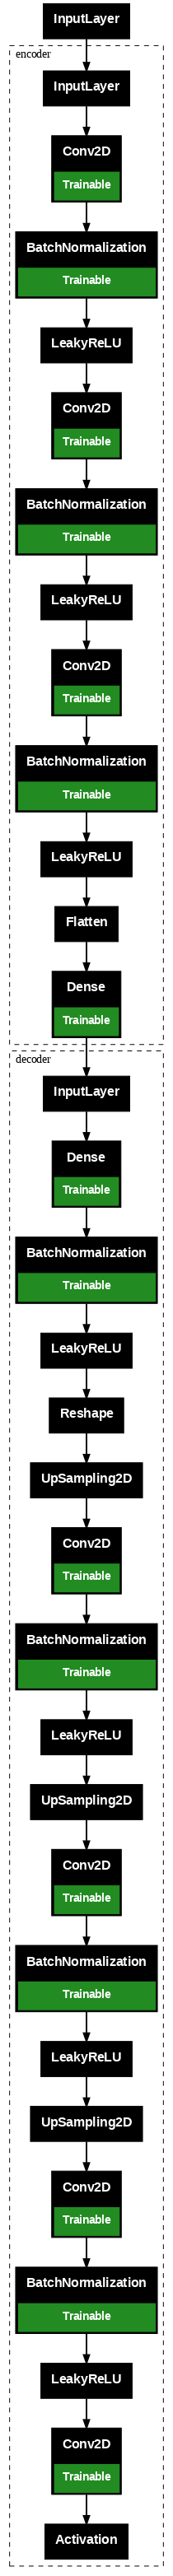

In [ ]:
autoencoder = get_autoencoder()

# Print a detailed summary of the autoencoder with expanded nested layers and trainable parameters.
autoencoder.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the autoencoder architecture.
tf.keras.utils.plot_model(autoencoder, show_trainable=True, expand_nested=True, dpi=70)

In [ ]:
# Initialize the optimizer with the defined learning rate
optimizer = tf.optimizers.Adam(learning_rate)

# Compile the autoencoder with Adam optimizer and mean squared error loss
autoencoder.compile(optimizer=optimizer, loss=tfk.losses.MeanSquaredError())

In [ ]:
# Train the autoencoder model
history = autoencoder.fit(
    X_train,
    X_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, X_val),
    callbacks=[
        tfk.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=10, factor=0.1, min_lr=1e-4),
    ],
    verbose=1
).history

# Calculate and print the final validation loss
final_val_loss = round(min(history['val_loss']), 4)
print(f'Final validation loss: {final_val_loss}')

# Save the trained model to a file with the loss included in the filename
model_filename = f'autoencoder_{final_val_loss}.keras'
autoencoder.save(model_filename)

# Delete the model to free up resources
del autoencoder

Epoch 1/1000
391/391 ━━━━━━━━━━━━━━━━━━━━ 27s 40ms/step - loss: 0.0606 - val_loss: 0.0531 - learning_rate: 0.0010
Epoch 2/1000
391/391 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - loss: 0.0388 - val_loss: 0.0409 - learning_rate: 0.0010
Epoch 3/1000
391/391 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0373 - val_loss: 0.0397 - learning_rate: 0.0010
Epoch 4/1000
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.0365 - val_loss: 0.0381 - learning_rate: 0.0010
Epoch 5/1000
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.0359 - val_loss: 0.0367 - learning_rate: 0.0010
Epoch 6/1000
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 0.0355 - val_loss: 0.0357 - learning_rate: 0.0010
Epoch 7/1000
391/391 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.0352 - val_loss: 0.0349 - learning_rate: 0.0010
Epoch 8/1000
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 0.0349 - val_loss: 0.0346 - learning_rate: 0.0010
Epoch 9/1000
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.0347 - val_loss: 0.0343 - le

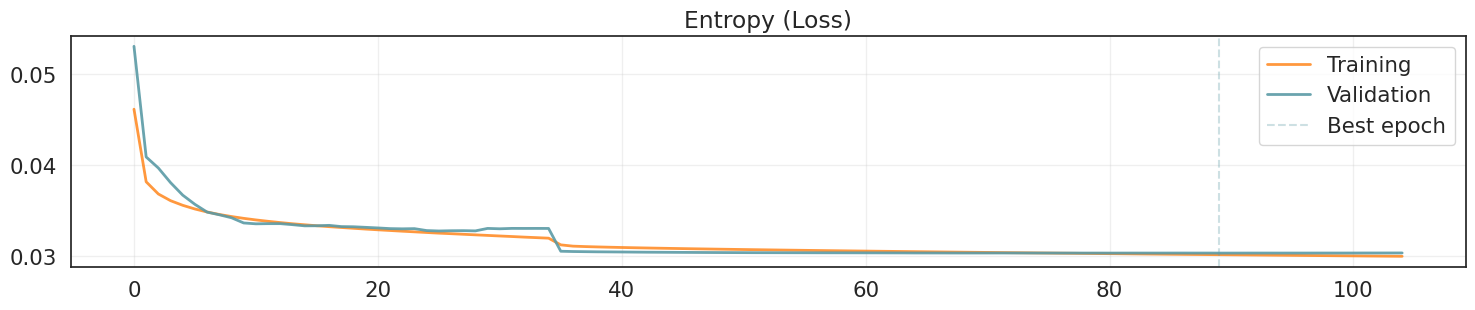

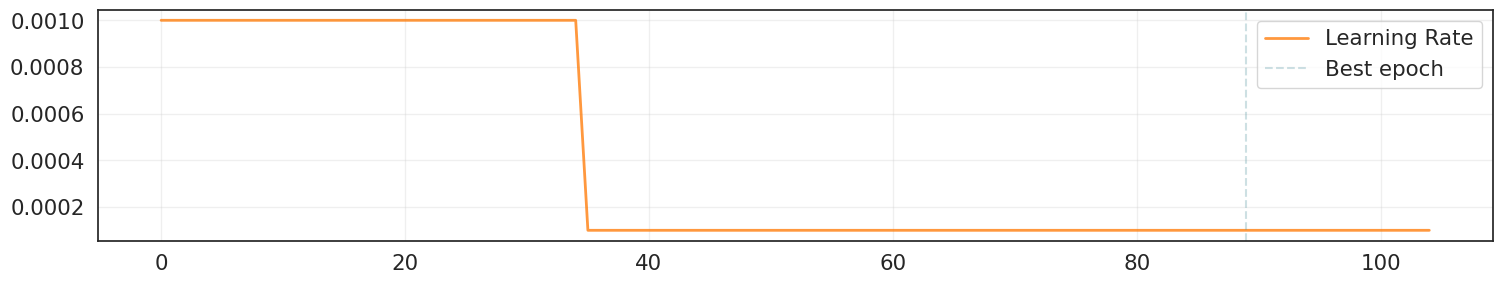

In [ ]:
# Identify the best epoch based on minimum validation loss
best_epoch = np.argmin(history['val_loss'])

# Plot training and validation loss
plt.figure(figsize=(18,3))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=.9, color='#5a9aa5', linewidth=2)
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Entropy (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

# Plot learning rate
plt.figure(figsize=(18,3))
plt.plot(history['learning_rate'], label='Learning Rate', alpha=.8, color='#ff7f0e', linewidth=2)
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

## 🕹️ Use the Model - Make Inference

### Autoencoder with 2-Dimensional Latent Space

In [ ]:
# Load the pre-trained autoencoder model
autoencoder = tfk.models.load_model('autoencoder_0.0304.keras')

# Extract the encoder component from the autoencoder
encoder = autoencoder.get_layer('encoder')

# Extract the decoder component from the autoencoder
decoder = autoencoder.get_layer('decoder')

#### Reconstruct Data

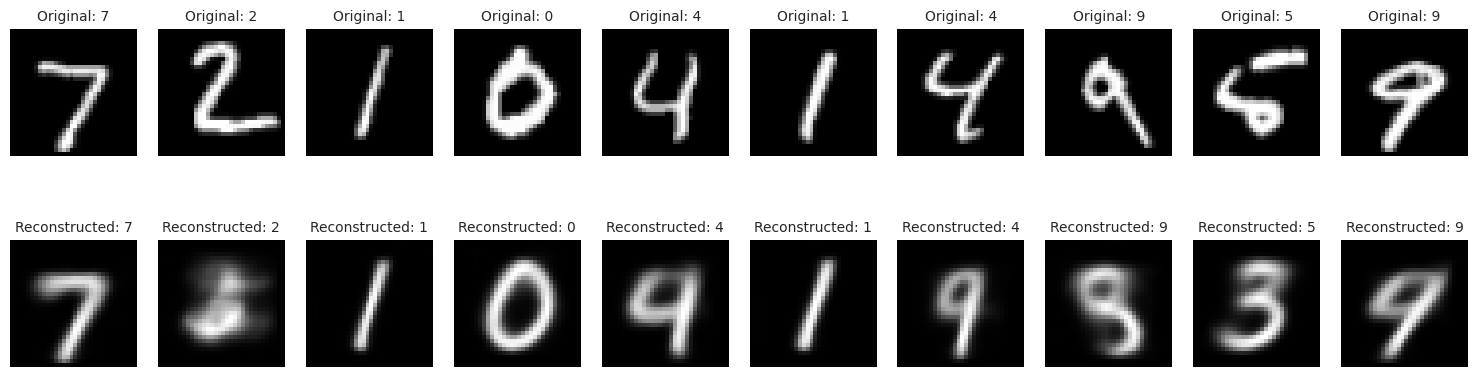

In [ ]:
# Configuration and model prediction
num_col = 10
predictions = autoencoder.predict(X_test[:num_col], verbose=0)

# Set up plot dimensions
fig, axes = plt.subplots(2, num_col, figsize=(15, 5))

# Loop through the grid and populate subplots
for i in range(num_col * 2):
    ax = axes[i // num_col, i % num_col]
    ax.axis('off')

    # Display original images on the top row
    if i < num_col:
        ax.imshow(np.squeeze(X_test[i]), cmap='gray')
        ax.set_title(f'Original: {y_test[i]}', fontsize=10)

    # Display reconstructed images on subsequent rows
    else:
        ax.imshow(np.squeeze(predictions[i - num_col]), cmap='gray')
        ax.set_title(f'Reconstructed: {y_test[i - num_col]}', fontsize=10)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

#### Project Data Into Latent Space

In [ ]:
def plot_label_clusters(encoder, data, labels, samples=10000):
    # Generate latent space representations
    z_mean = encoder.predict(data[:samples], verbose=0)

    # Apply TSNE if dimensions > 2
    if z_mean.shape[-1] != 2:
        tsne = TSNE(n_components=2, random_state=42)
        z_mean = tsne.fit_transform(z_mean)

    # Create figure object explicitly
    fig = go.Figure()

    # Add traces for each label
    unique_labels = sorted(set(labels[:samples]))
    colors = px.colors.qualitative.D3[:len(unique_labels)]

    for label, color in zip(unique_labels, colors):
        mask = labels[:samples] == label
        fig.add_trace(go.Scatter(
            x=z_mean[mask, 0],
            y=z_mean[mask, 1],
            mode='markers',
            name=str(label),
            marker=dict(
                size=5,
                color=color,
                line=dict(width=0)
            ),
            showlegend=True
        ))

    # Configure layout with explicit positioning
    fig.update_layout(
        # Basic setup
        showlegend=True,
        template='plotly_white',
        width=950,
        height=800,

        # Title configuration
        title=dict(
            text='Latent Space Visualization',
            font=dict(size=22),
            pad=dict(t=20),
            yref='container',
            y=0.95
        ),

        # Axes configuration
        xaxis=dict(
            title='First Component',
            showgrid=True,
            gridwidth=1,
            gridcolor='lightgray',
            zeroline=False,
            title_font=dict(size=16),
            tickfont=dict(size=14),
            title_standoff=15
        ),
        yaxis=dict(
            title='Second Component',
            showgrid=True,
            gridwidth=1,
            gridcolor='lightgray',
            zeroline=False,
            title_font=dict(size=16),
            tickfont=dict(size=14),
            title_standoff=15
        ),

        # Legend configuration
        legend=dict(
            title=dict(text='Labels'),
            yanchor='top',
            y=0.99,
            xanchor='right',
            x=0.99,
            bgcolor='rgba(255, 255, 255, 0.8)',
            bordercolor='lightgray',
            borderwidth=1,
            itemsizing='constant',
            font=dict(size=14)
        ),

        # Margins
        margin=dict(l=80, r=80, t=100, b=80)
    )

    return fig

# Project training data into latent space
plot_label_clusters(encoder, X_train, y_train)

#### Sample Data From Latent Space

In [ ]:
def plot_latent_space_optimized(decoder, x_lim, y_lim, n_per_dim=20, digit_size=32):
    # Generate a grid of values within provided x and y limits
    grid_x = np.linspace(x_lim[0], x_lim[1], n_per_dim)
    grid_y = np.linspace(y_lim[0], y_lim[1], n_per_dim)[::-1]
    xv, yv = np.meshgrid(grid_x, grid_y)

    # Create latent vectors for each grid point
    latent_dim = decoder.input_shape[-1]
    z_samples = np.stack([np.linspace(x, y, latent_dim) for x, y in zip(xv.flatten(), yv.flatten())])

    # Decode the latent vectors into images
    x_decoded = decoder.predict(z_samples, verbose=0)
    digits = x_decoded.reshape(n_per_dim, n_per_dim, digit_size, digit_size)

    # Combine the individual images into a single large image
    figure = np.block([[digits[i, j] for j in range(n_per_dim)] for i in range(n_per_dim)])

    # Plot the large image using Plotly
    fig = go.Figure(data=go.Heatmap(
        z=figure,
        x=np.round(grid_x, 1),
        y=np.round(grid_y, 1),
        colorscale="Gray",
        showscale=False
    ))

    fig.update_layout(
        title='Latent Space - Uniform Samples',
        xaxis_title='$z_0$',
        yaxis_title='$z_1$',
        title_font_size=20,
        font=dict(
            size=16,
            color="black"
        ),
        title_x=0.5,
        width=950,
        height=950
    )

    fig.show()

# Sample data from latent space
plot_latent_space_optimized(decoder, [-5, 5], [-5, 5])

### Autoencoder with 64-Dimensional Latent Space

In [ ]:
# Load the pre-trained autoencoder model
autoencoder = tfk.models.load_model('autoencoder64_0.0008.keras')

# Extract the encoder component from the autoencoder
encoder = autoencoder.get_layer('encoder')

# Extract the decoder component from the autoencoder
decoder = autoencoder.get_layer('decoder')

#### Reconstruct Data

In [ ]:
# Configuration and model prediction
num_col = 10
predictions = autoencoder.predict(X_test[:num_col], verbose=0)

# Set up plot dimensions
fig, axes = plt.subplots(2, num_col, figsize=(15, 5))

# Loop through the grid and populate subplots
for i in range(num_col * 2):
    ax = axes[i // num_col, i % num_col]
    ax.axis('off')

    # Display original images on the top row
    if i < num_col:
        ax.imshow(np.squeeze(X_test[i]), cmap='gray')
        ax.set_title(f'Original: {y_test[i]}', fontsize=10)

    # Display reconstructed images on subsequent rows
    else:
        ax.imshow(np.squeeze(predictions[i - num_col]), cmap='gray')
        ax.set_title(f'Reconstructed: {y_test[i - num_col]}', fontsize=10)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

#### Project Data Into Latent Space

In [ ]:
 # Project training data into latent space
plot_label_clusters(encoder, X_train, y_train)